In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, time
from PIL import Image
import cv2
import glob
import signal

from IPython import display
%matplotlib inline

# Init cameras
## Get available cameras

In [2]:
def get_cameras(cams=6):
    arr = []
    for index in range(cams):
        print(index)
        cap = cv2.VideoCapture(index)
        if not cap.read()[0]:
            continue
        else:
            arr.append(index)
        cap.release()
    return arr

In [3]:
cid = get_cameras()
cid 

0
1
2
3
4
5


[0, 1, 4]

# Threaded camera reading

In [4]:
from cameras.threaded_cam import Camera


In [5]:
cams = [Camera(i, buf_size=10) for i in cid]
ps  = [c.start() for c in cams]


trying to opentrying to open Camera1
 trying to open Camera4
Camera0
Param::auto exp? 0.25
Param::exp time 0.005002000800320128
Opened Camera4
Param::auto exp? 0.25
Param::exp time 0.005002000800320128
Opened Camera0
Param::auto exp? 0.25
Param::exp time 0.005002000800320128
Opened Camera1


Read 15 frames from Camera0 with ints 11.820026475694446
Read 15 frames from Camera1 with ints 14.453601056134259
Read 15 frames from Camera4 with ints 15.96308673321759


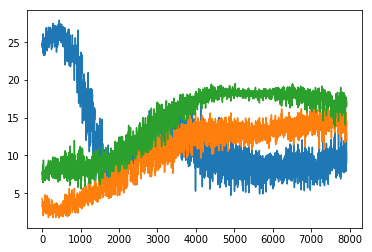

KeyboardInterrupt: 

In [6]:
import server
server.start()
rot_value = [0]
server.bind(rot_value)

means = []
phases = []
while True:
    display.clear_output()
    f, axs = plt.subplots(1,len(cams), figsize=(11,10*len(cams)))
    
    imgs = []
    for c, ax in zip(cams, axs):
        cum, cnt = 0,0
        while not c.buffer.empty():
            im = c.buffer.get() 
            cum += np.mean(im)
            cnt += 1
        mean = cum/cnt
        phases.append(rot_value[0])
        print(f"Read {cnt} frames from {c.name} with ints {mean}")
        means.append( mean )
        ax.imshow(im)
    plt.pause(0.1)
    f, axs = plt.subplots()
    szs = [ c.buffer.qsize() for c in cams]
    print("buffer sizes:", szs)
    x = np.array(means)
    x = x.reshape(-1, len(cams)).T
    for l  in x:
        axs.plot(l)
    #display.display(plt.show())
plt.show()
        
    

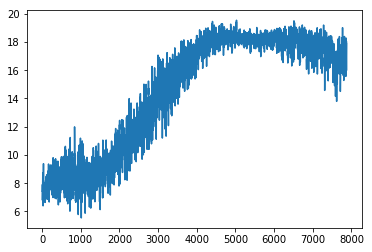

In [7]:
d = np.array(means).reshape(-1,3).T
phases_to_write = np.array(phases).reshape(-1,3).T
plt.plot(d[2][:-50])

In [8]:
phases_to_write

array([[0.        , 0.0110471 , 0.01079592, ..., 0.00125118, 0.00125118,
        0.00125118],
       [0.        , 0.0110471 , 0.01079592, ..., 0.00125118, 0.00125118,
        0.00125118],
       [0.        , 0.0110471 , 0.01079592, ..., 0.00125118, 0.00125118,
        0.00125118]])

In [9]:
!pwd

/root/Desktop/quantTechLab/Experiment_run


In [10]:
time.strftime('%Y_%m-%d')

'2019_07-17'

In [11]:
# SAVING TO FILE
save_to="/root/Desktop/quantTechLab/data/auto_rotate/ints1.csv"
save_phases_to="/root/Desktop/quantTechLab/data/auto_rotate/ints2.csv"

In [13]:


print('total number of points: %i'%len(d))
## times = np.arange(0,len(intens),file_check_interval)
data = d
np.savetxt(save_to,data,delimiter=',',fmt='%10.5f')
print ("saved to %s"%save_to)


print('total number of points: %i'%len(phases_to_write))
## times = np.arange(0,len(intens),file_check_interval)
data = phases_to_write
np.savetxt(save_to,data,delimiter=',',fmt='%10.5f')
print ("saved to %s"%save_phases_to)

total number of points: 3
saved to /root/Desktop/quantTechLab/data/auto_rotate/ints1.csv
total number of points: 3
saved to /root/Desktop/quantTechLab/data/auto_rotate/ints2.csv
path /
fail /


67.175.140.143 - - [17/Jul/2019 00:51:14] "GET / HTTP/1.1" 400 -


path /
fail /


139.162.119.197 - - [17/Jul/2019 01:52:12] "GET / HTTP/1.1" 400 -


path /shell?busybox
fail /shell?busybox


92.188.127.57 - - [17/Jul/2019 03:55:24] "GET /shell?busybox HTTP/1.1" 400 -


path /
fail /


188.168.198.105 - - [17/Jul/2019 04:17:12] "GET / HTTP/1.1" 400 -


path http://110.249.212.46/testget?q=23333&port=80
fail http://110.249.212.46/testget?q=23333&port=80
path http://110.249.212.46/testget?q=23333&port=80
fail http://110.249.212.46/testget?q=23333&port=80
path http://110.249.212.46/testget?q=23333&port=80
fail http://110.249.212.46/testget?q=23333&port=80


110.249.212.46 - - [17/Jul/2019 05:37:02] "GET http://110.249.212.46/testget?q=23333&port=80 HTTP/1.1" 400 -
110.249.212.46 - - [17/Jul/2019 05:37:02] "GET http://110.249.212.46/testget?q=23333&port=80 HTTP/1.1" 400 -
110.249.212.46 - - [17/Jul/2019 05:37:02] "GET http://110.249.212.46/testget?q=23333&port=80 HTTP/1.1" 400 -


path http://110.249.212.46/testget?q=23333&port=80
fail http://110.249.212.46/testget?q=23333&port=80
path http://110.249.212.46/testget?q=23333&port=80
fail http://110.249.212.46/testget?q=23333&port=80


110.249.212.46 - - [17/Jul/2019 05:37:06] "GET http://110.249.212.46/testget?q=23333&port=80 HTTP/1.1" 400 -
110.249.212.46 - - [17/Jul/2019 05:37:06] "GET http://110.249.212.46/testget?q=23333&port=80 HTTP/1.1" 400 -
----------------------------------------
Exception happened during processing of request from ('185.53.88.40', 51519)
Traceback (most recent call last):
  File "/usr/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/lib/python3.7/http/server.py", line 426, in handle
    self.handle_one_request()
  File "/usr/lib/python3.7/http/server.py", line 394, in handl

path /
fail /


112.66.101.157 - - [17/Jul/2019 06:45:24] "GET / HTTP/1.1" 400 -


path /
fail /


112.66.101.157 - - [17/Jul/2019 06:45:24] "GET / HTTP/1.1" 400 -


path /
fail /


112.66.101.157 - - [17/Jul/2019 06:45:25] "GET / HTTP/1.1" 400 -


path /currentsetting.htm
fail /currentsetting.htm


112.66.101.157 - - [17/Jul/2019 06:45:26] "GET /currentsetting.htm HTTP/1.1" 400 -


path /
fail /


112.66.101.157 - - [17/Jul/2019 06:45:29] "GET / HTTP/1.1" 400 -


path /winbox.png
fail /winbox.png


112.66.101.157 - - [17/Jul/2019 06:45:30] "GET /winbox.png HTTP/1.1" 400 -


path /cgi-bin/nobody/Machine.cgi?action=get_capability
fail /cgi-bin/nobody/Machine.cgi?action=get_capability


112.66.101.157 - - [17/Jul/2019 06:45:30] "GET /cgi-bin/nobody/Machine.cgi?action=get_capability HTTP/1.1" 400 -


path /cgi-bin/user/Config.cgi?.cab&action=get&category=Account.*
fail /cgi-bin/user/Config.cgi?.cab&action=get&category=Account.*


112.66.101.157 - - [17/Jul/2019 06:45:31] "GET /cgi-bin/user/Config.cgi?.cab&action=get&category=Account.* HTTP/1.1" 400 -


path /device_description.xml
fail /device_description.xml


112.66.101.157 - - [17/Jul/2019 06:45:32] "GET /device_description.xml HTTP/1.1" 400 -


path /current_config/passwd
fail /current_config/passwd


112.66.101.157 - - [17/Jul/2019 06:45:32] "GET /current_config/passwd HTTP/1.1" 400 -


path /login/login.html
fail /login/login.html


112.66.101.157 - - [17/Jul/2019 06:45:36] "GET /login/login.html HTTP/1.1" 400 -


path /images/logo.gif
fail /images/logo.gif


112.66.101.157 - - [17/Jul/2019 06:45:40] "GET /images/logo.gif HTTP/1.1" 400 -


path /fdsrwe
fail /fdsrwe


112.66.101.157 - - [17/Jul/2019 06:45:40] "GET /fdsrwe HTTP/1.1" 400 -


path /login.htm
fail /login.htm


112.66.101.157 - - [17/Jul/2019 06:45:41] "GET /login.htm HTTP/1.1" 400 -


path /qnfxcjqr
fail /qnfxcjqr


112.66.101.157 - - [17/Jul/2019 06:45:42] "GET /qnfxcjqr HTTP/1.1" 400 -


path /
fail /


112.66.101.157 - - [17/Jul/2019 06:45:42] "GET / HTTP/1.1" 400 -


path /smb_scheduler/
fail /smb_scheduler/


112.66.101.157 - - [17/Jul/2019 06:45:44] "GET /smb_scheduler/ HTTP/1.1" 400 -


path /
fail /


112.66.101.157 - - [17/Jul/2019 06:45:45] "GET / HTTP/1.1" 400 -


path /
fail /


178.234.98.74 - - [17/Jul/2019 07:09:25] "GET / HTTP/1.0" 400 -


path /
fail /


190.182.72.193 - - [17/Jul/2019 07:15:48] "GET / HTTP/1.1" 400 -


path /
fail /


109.196.247.252 - - [17/Jul/2019 07:32:47] "GET / HTTP/1.1" 400 -


path /
fail /


176.207.4.172 - - [17/Jul/2019 08:05:52] "GET / HTTP/1.1" 400 -


path /
fail /


31.40.97.98 - - [17/Jul/2019 10:11:28] "GET / HTTP/1.1" 400 -


path /
fail /


71.6.232.4 - - [17/Jul/2019 11:01:35] "GET / HTTP/1.1" 400 -


path /setup.cgi?next_file=netgear.cfg&todo=syscmd&cmd=busybox&curpath=/&currentsetting.htm=1
fail /setup.cgi?next_file=netgear.cfg&todo=syscmd&cmd=busybox&curpath=/&currentsetting.htm=1


78.187.198.26 - - [17/Jul/2019 12:07:36] "GET /setup.cgi?next_file=netgear.cfg&todo=syscmd&cmd=busybox&curpath=/&currentsetting.htm=1 HTTP/1.1" 400 -


path /
fail /


103.47.218.125 - - [17/Jul/2019 12:31:40] "GET / HTTP/1.1" 400 -


path /
fail /


171.252.160.27 - - [17/Jul/2019 13:35:11] "GET / HTTP/1.1" 400 -


path /
fail /
path /
fail /
path /
fail /


176.126.45.242 - - [17/Jul/2019 13:46:15] "GET / HTTP/1.1" 400 -
176.126.45.242 - - [17/Jul/2019 13:46:15] "GET / HTTP/1.1" 400 -
176.126.45.242 - - [17/Jul/2019 13:46:15] "GET / HTTP/1.1" 400 -
----------------------------------------
Exception happened during processing of request from ('185.53.88.131', 51568)
Traceback (most recent call last):
  File "/usr/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/lib/python3.7/http/server.py", line 426, in handle
    self.handle_one_request()
  File "/usr/lib/python3.7/http/server.py", line 394, in handle_one_request
    self

path /
fail /


23.225.121.240 - - [17/Jul/2019 15:04:14] "GET / HTTP/1.1" 400 -


path /
fail /


23.225.121.240 - - [17/Jul/2019 15:04:15] "GET / HTTP/1.1" 400 -
----------------------------------------
Exception happened during processing of request from ('77.247.110.219', 63041)
Traceback (most recent call last):
  File "/usr/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/lib/python3.7/http/server.py", line 426, in handle
    self.handle_one_request()
  File "/usr/lib/python3.7/http/server.py", line 394, in handle_one_request
    self.raw_requestline = self.rfile.readline(65537)
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.

path /
fail /


190.114.41.7 - - [17/Jul/2019 16:21:17] "GET / HTTP/1.1" 400 -


# Graveyard

Below are snippets that can be usefull for tweaking, but most probably are not needed anymore.

This code rests in peace


In [4]:
np.array([1,22,33,5,27,39]).reshape(2,3).T

array([[ 1,  5],
       [22, 27],
       [33, 39]])

In [4]:

#
# Attach interrupt handler to release cameras after sigterm
def release_caps(caps):
    for cap in caps:
        try:
            cap.release()
            print("Released camera")
        except Exception as e:
            print("Error",e)
        
def gen_int_handler(caps):
    def int_handler(signum, frame):
        print("Got sigterm")
        release_caps(caps)
        raise  Exception('Interrupt') 
        #cv2.destroyAllWindows()
    return int_handler

def init_caps(idx_list):
    print(f"Init cameras {idx_list}")
    caps = [cv2.VideoCapture(i) for i in (idx_list) ]

    # Set exposition time-------
    for cap in caps:
        if not cap.isOpened():
            print("Failed to init")
        cap.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.25)
        # 10 was found to be the smallest value
        cap.set(cv2.CAP_PROP_EXPOSURE, 0.01)
        print("Param::auto exp?",cap.get(cv2.CAP_PROP_AUTO_EXPOSURE))
        print("Param::exp time", cap.get(cv2.CAP_PROP_EXPOSURE))

    signal.signal(signal.SIGINT, gen_int_handler(caps))
    return caps
caps = init_caps(cid)

Init cameras [0, 1, 4]
Param::auto exp? 0.25
Param::exp time 0.010004001600640256
Param::auto exp? 0.25
Param::exp time 0.010004001600640256
Param::auto exp? 0.25
Param::exp time 0.010004001600640256


In [5]:
release_caps(caps)

Released camera
Released camera
Released camera


In [ ]:

class CameraNoneException(Exception):
    def __init___(self,dErrorArguments):
        Exception.__init__(self,"Camera read None {0}".format(dErrArguments))
        self.dErrorArguments = dErrorArguements
        
        
def read_cameras(caps, idxs, retry_cnt=0):
    results = []
    for camera_idx, cap in zip(idxs,caps):
        print(f"Reading {camera_idx}")
        if cap.isOpened():
            ret, img = cap.read()
        else:
            print("Camera is closed.")
            ret = None
        if not ret:
            print(f"Camera {camera_idx} returned None")

            if retry_cnt<3:
                release_caps(caps)
                time.sleep(0.1)
                print(f"Trying to connect to {camera_idx} only")
                cap_retry = init_caps([camera_idx])
                time.sleep(0.1)
                res_retry = read_cameras(cap_retry, [camera_idx], retry_cnt=retry_cnt+1)
                results += res_retry
            else:
                print(f"!>>\nCamera {camera_idx} is not working at all")
                continue
        else:
            results.append(img)
    return results

while True:
    display.clear_output()
    results = read_cameras(caps, cid)
    print(len(results))
    for res in results:
        plt.imshow(res)
        plt.show()
        plt.close()
    time.sleep(0.5)


In [ ]:
# Main loop

while True:
    for camera_idx, cap in zip(cams_idxs,caps):
        ret, img = cap.read()
        if not ret:
            print(f"Camera {camera_idx} returned None")
            print("Releasing all cameras and trying this camera only")
    if (tries==retry_cnt):
        print("Camera %i is not working. Giving up."%num)
        print()
        break
    time.sleep(retry_sec)


In [ ]:
import cv2
import threading
import time
# Threaded camera reader

class camThread(threading.Thread):
    def __init__(self, img_array, camID, cap):
        threading.Thread.__init__(self)
        self.camID = camID
        self.cap = cap
        self.array = img_array
    def run(self):t
        print ("Starting %s"% self.camID)
        if self.cap.isOpened():  # try to get the first frame
            rval, frame = self.cap.read()
            time.sleep(0)
            if not rval:
                print("fail", self.camID)
                frames = read

        #pic = take_pic(self.camID)
            self.array.append(frame)
        else:
            print("fail")

def take_pic(camID):
    cam = cv2.VideoCapture(camID)
    if cam.isOpened():  # try to get the first frame
        time.sleep(0)
        rval, frame = cam.read()
        time.sleep(0)
        print('read')
        return frame
    else:
        rval = False

# Create two threads as follows
a = []
b = []

thread1 = camThread(a, 0, caps[0])
thread2 = camThread(b, 2, caps[1])
thread1.start()
thread2.start()

In [ ]:
# a library of some unknown buddy from stackoverflow
import cvpubsubs.webcam_pub as w
from cvpubsubs.window_sub import SubscriberWindows

t1 = w.VideoHandlerThread(4)


t1.start()


SubscriberWindows(window_names=['cammy'],
              video_sources=[4]
              ).loop()

t1.join()
#t2.join()
#t3.join()